# RecSys Challenge - Model Training and Evaluation Notebook

*Alvin Karanja*

This notebook is used to train and evaluate the models developed as part of the RecSys Challenge. This notebook contains strictly the training and evaluation code, whilst the data preparation, feature engineering and analysis is done in a separate notebook.

Note that we use helper code from the `utils.py` file located in this directory to assist in training and evaluation. This includes several key functions that assist in the training and evaluation process, such as:

- `evaluation_score`: Computes the evaluation score based on the predictions and ground truth.
- `optimise_threshold`: Optimises the threshold for the model based on the evaluation score.
- `evaluate_model`: Evaluates the model's predictions against the test set and prints various metrics.

Additionally, the source code for the FNN model is located in the `fnn_model.py` file in the same directory.

In [1]:
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from fnn_model import FNNModel
from lightgbm import LGBMClassifier
from utils import (
    optimise_threshold,
    evaluate_stage, 
    evaluate_model
)

# Development Data
TEST_SESSION = './data/test_session.csv'
VAL_SESSION = './data/val_session.csv'
TRAIN_VAL_SESSION = './data/train_val_session.csv'
TRAIN_SESSION = './data/train_session.csv'

TEST_ITEM = './data/test_item.csv'
VAL_ITEM = './data/val_item.csv'
TRAIN_VAL_ITEM = './data/train_val_item.csv'
TRAIN_ITEM = './data/train_item.csv'

RESULT_SESSIONS = './results/session_predictions.csv'
RESULT_ITEMS = './results/item_predictions.csv'

# Models - FNN models take a long time 
# to train, so we save them after training
FNN_MODEL_PHASE_1 = './models/phase_1_fnn_model.pth'
FNN_MODEL_PHASE_2 = './models/phase_2_fnn_model.pth'

# Constants
FIG_SIZE = (8, 6)
RANDOM_STATE = 42

# Assure directories exist
os.makedirs('./tmp', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

# --- Features ---

session_features = [
    'session_length_z',
    'session_clicks_z',
    'day_of_week',
    'hour_sin', 
    'hour_cos',
    'max_item_propensity',
    'avg_item_propensity',
    'unique_items_z',
    'unique_categories_z',
]

# We drop features for score calculation
session_features_shrink = session_features + [
    'time',
    'session_clicks',
    'session_length',
    'unique_items',
    'unique_categories',
]

item_features = [
    'item_clicks_z',
    'item_time_z',
    'day_of_week',
    'hour_sin',
    'hour_cos',
    'item_propensity',
    'item_categories_z',
]

# We drop features for score calculation
item_features_shrink = item_features + [
    'time',
    'item_clicks',
    'item_time',
    'item_categories',
]

## 1. Phase 1 Training: Session Purchase Classification

We begin by training a model to predict whether a session will result in a purchase. We train each core model on the session data using the training set, and optimise the threshold for each model based on the evaluation score using the validation set. Due to the skew in the data, we upsample the minority class to ensure that the model is able to learn from both classes effectively.

*Note: Previous training sessions did not use upsampling, but this was found to considerably improve the performance of the model*.

In [ ]:
# Load session training data and
# extract features and labels
train_session_df = pd.read_csv(TRAIN_SESSION)
val_session_df = pd.read_csv(VAL_SESSION)

# Upsample training data to balance things out
majority_class = train_session_df[train_session_df['session_purchase'] == 0]
minority_class = train_session_df[train_session_df['session_purchase'] == 1]

minority_upsampled = resample(
    minority_class,
    replace=True,  # sample with replacement
    n_samples=len(majority_class),  # to match majority class
    random_state=RANDOM_STATE  # reproducible results
)

train_session_df: pd.DataFrame = pd.concat([majority_class, minority_upsampled]) # type: ignore
train_session_df = train_session_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Shrink dataframes for score calculation
shrunk_train_session_df = train_session_df.copy().drop(session_features_shrink, axis=1)
shrunk_val_session_df = val_session_df.copy().drop(session_features_shrink, axis=1)

x_train = train_session_df[session_features].to_numpy()
y_train = train_session_df['session_purchase'].to_numpy()
x_val = val_session_df[session_features].to_numpy()
y_val = val_session_df['session_purchase'].to_numpy()

### 1.1 Logistic Regression

We train a logistic regression model to predict whether a session will result in a purchase. We then optimise the threshold for the model to maximise the evaluation measure.

--- Model: Phase 1: Logistic Regression ---
Optimal Threshold: 0.99
Evaluation Score: -7.8810
ROC AUC: 0.7957
Precision: 0.3826
Recall: 0.0034


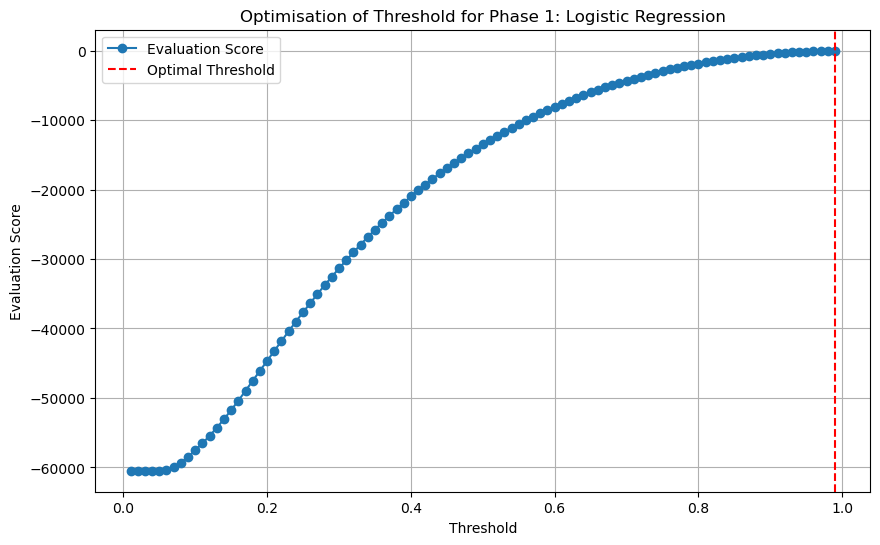

In [7]:
# Train Logistic Regression Model
phase_1_logistic = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
)
phase_1_logistic.fit(x_train, y_train)

# Predict on validation set
phase_1_logistic_pred_df = shrunk_val_session_df.copy()
phase_1_logistic_pred_df['session_prob'] = phase_1_logistic.predict_proba(x_val)[:, 1]

# Optimise threshold and evaluate
phase_1_best_logistic_threshold = optimise_threshold(
    'Phase 1: Logistic Regression',
    phase_1_logistic_pred_df,
    shrunk_val_session_df,
)

In [8]:
# Print Logistic Regression Weights
print("Phase 1: Logistic Regression Weights")
for feature, weight in zip(session_features, phase_1_logistic.coef_[0]):
    print(f"{feature}: {weight:.4f}")

Phase 1: Logistic Regression Weights
session_length_z: 0.4607
session_clicks_z: 1.0633
day_of_week: 0.1406
hour_sin: -0.0443
hour_cos: -0.2867
max_item_propensity: 3.4152
avg_item_propensity: 17.3968
unique_items_z: -0.8140
unique_categories_z: 0.1170


Observing the results, we note that the logistic regression model does not perform well on the validation set, having a net negative score for an optimal threshold of 0.99. This means that the model is not able to reliably predict whether a session will result in a purchase, this is reflected in the very low recall of the model of 0.0034, which shows the model does not sufficiently predict positive cases, resulting in a net negative score when evaluated using the evaluation measure.

Observing the regression coefficients, we note that the propensity features are particularly informative, and likely form the majority of the signal in the data. However despite this, the model is not able to reliably predict whether a session will result in a purchase, it is likely that other features have non linear relationships with the target variable, and thus a linear model such as logistic regression is not able to capture these relationships.

### 1.2 Gradient Boosting

We train a gradient boosting model to predict whether a session will result in a purchase. We use a standard set of hyperparameters for the model and optimise the threshold for the model to maximise the evaluation measure. Hyperparameter tuning is left for future work.


--- Model: Phase 1: Gradient Boosting ---
Optimal Threshold: 0.95
Evaluation Score: 2.8107
ROC AUC: 0.8154
Precision: 0.5235
Recall: 0.0084


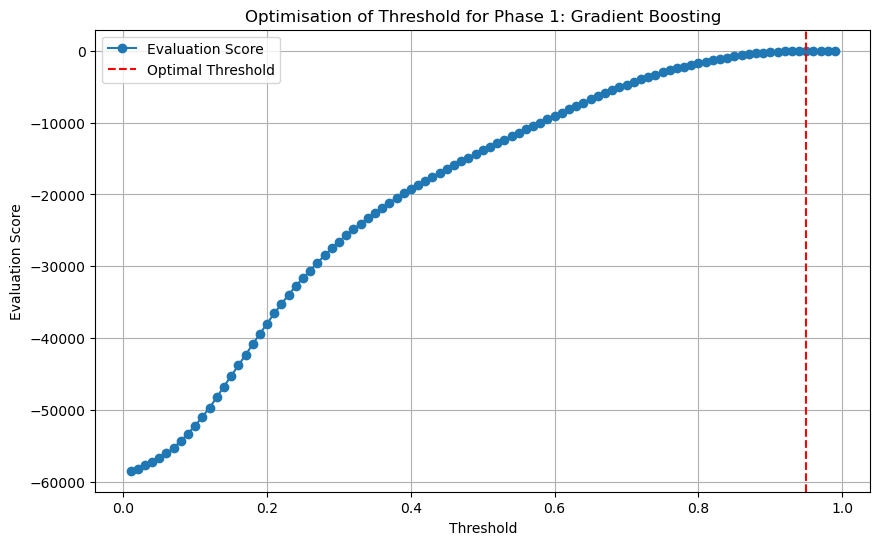

In [9]:
# Train Gradient Boosting Model
phase_1_gbm = LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_estimators=1000,
    verbose=-1
)
phase_1_gbm.fit(x_train, y_train)

# Predict on validation set
phase_1_gbm_pred_df = shrunk_val_session_df.copy()
phase_1_gbm_pred_df['session_prob'] = phase_1_gbm.predict_proba(x_val)[:, 1] # type: ignore

# Optimise threshold and evaluate
phase_1_best_gbm_threshold = optimise_threshold(
    'Phase 1: Gradient Boosting',
    phase_1_gbm_pred_df,
    shrunk_val_session_df,
)

Gradient boosting appears to perform well on the validation set, with a net positive score for an optimal threshold of 0.95. This means that in the event the model is implemented with a higher threshold, it is likely to result in a net positive score. This is likely due to the recall of this model also being quite low at 0.0084, however, the small increase in performance is likely due to the model being able to capture more of the signal in the data, and thus being able to predict more positive cases than the logistic regression model.

### 1.3 Feedforward Neural Network

We train a feedforward neural network to predict whether a session will result in a purchase. We then optimise the threshold for the model to maximise the evaluation measure. Note that we use a default configuration for the model, with a hidden layer of size 8, batch size of 2048 and 50 training epochs. This is done to keep the training time reasonable, hyperparameter tuning is left for further work.

Starting training...
Hidden layer size: 8
Batch size: 2048
Number of epochs: 50

Epoch [10/50], Loss: 0.5286
Epoch [20/50], Loss: 0.5275
Epoch [30/50], Loss: 0.5273
Epoch [40/50], Loss: 0.5273
Epoch [50/50], Loss: 0.5273
Model saved to ./models/phase_1_fnn_model.pth
--- Model: Phase 1: Feedforward Neural Network ---
Optimal Threshold: 0.99
Evaluation Score: -0.7165
ROC AUC: 0.8085
Precision: 0.3333
Recall: 0.0002


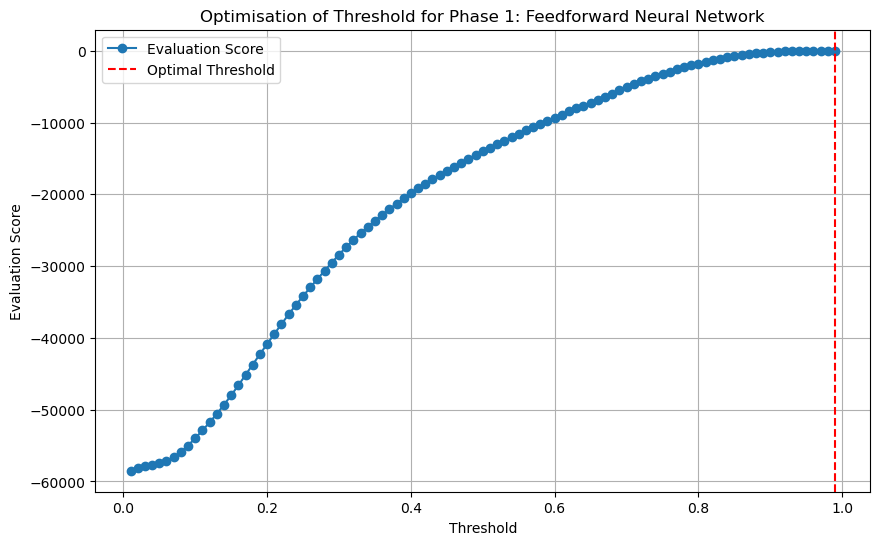

In [3]:
# Train Feedforward Neural Network Model
fnn_model = FNNModel(
    input_size=len(session_features),
    hidden_size=8,
    batch_size=2048,
)

fnn_model.train_model(
    x_train,
    y_train,
    num_epochs=50,
)

# Save model
fnn_model.save_model(FNN_MODEL_PHASE_1)

# Predict on validation set
phase_1_fnn_pred_df = shrunk_val_session_df.copy()
phase_1_fnn_pred_df['session_prob'] = fnn_model.predict_prob(x_val)

# Optimise threshold and evaluate
phase_1_best_fnn_threshold = optimise_threshold(
    'Phase 1: Feedforward Neural Network',
    phase_1_fnn_pred_df,
    shrunk_val_session_df,
)

Similar to the Logistic Regression model, the FNN model does not perform well on the validation set, having a net negative score for an optimal threshold of 0.99. This model is therefore also not suitable to predict whether a session will result in a purchase. It is feasible that a more complex model with more hidden layers and a larger number of epochs may be able to capture the signal in the data, however, this is left for future work due to the long training time required for such a model.

In [4]:
# Free up memory
del x_train, y_train, x_val, y_val
del train_session_df, val_session_df, shrunk_train_session_df, shrunk_val_session_df

## Phase 2 Training: Item Purchase Classification

In this phase, we train a model to predict whether an item will be purchased in a session. This is done by training a model on sessions that resulted in a purchase and using the item features as input.

The purpose of using sessions that resulted in a purchase is to ensure that the model is able to learn from the items that are actually purchased, rather than all items in the session. This allows the model to focus on the items that are more likely to be purchased, and thus improve its performance.

It is likely that this would make the model "overoptimistic" in its predictions, as it is only trained on items that were purchased in a session. However, this is not necessarily a bad thing as the evaluation measure does not penalise the model for false positives, and thus training a model on items that were purchased in a session is likely to result in a model that is more precise in its predictions, which is desirable to maximise the evaluation score.

Note that here when we optimise the threshold for the model, we do so only considering the Jaccard portion of the evaluation measure, as the model is trained on items that were purchased in a session, and thus the Jaccard portion of the evaluation measure is more relevant to the model's performance.

In [ ]:
# Load item training data and
# extract features and labels
train_item_df = pd.read_csv(TRAIN_ITEM)
val_item_df = pd.read_csv(VAL_ITEM)

# Upsample training data to balance things out
majority_class = train_item_df[train_item_df['item_purchase'] == 0]
minority_class = train_item_df[train_item_df['item_purchase'] == 1]

minority_upsampled = resample(
    minority_class,
    replace=True,  # sample with replacement
    n_samples=len(majority_class),  # to match majority class
    random_state=RANDOM_STATE  # reproducible results
)

train_item_df: pd.DataFrame = pd.concat([majority_class, minority_upsampled]) # type: ignore
train_item_df = train_item_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Filter for sessions that resulted in a purchase
train_item_df = train_item_df[train_item_df['session_purchase'] == 1]
val_item_df = val_item_df[val_item_df['session_purchase'] == 1]

# Shrink dataframes for score calculation
shrunk_train_item_df = train_item_df.copy().drop(item_features_shrink, axis=1)
shrunk_val_item_df = val_item_df.copy().drop(item_features_shrink, axis=1)

x_train = train_item_df[item_features].to_numpy()
y_train = train_item_df['item_purchase'].to_numpy()

x_val = val_item_df[item_features].to_numpy()
y_val = val_item_df['item_purchase'].to_numpy()

### 2.1 Logistic Regression

We train a logistic regression model to predict whether an item will be purchased in a session. We then optimise the threshold for the model to maximise the evaluation measure.

--- Model: Phase 2: Logistic Regression ---
Optimal Threshold: 0.87
Evaluation Score: 44886.5985
ROC AUC: 0.7764
Precision: 0.5604
Recall: 0.9242


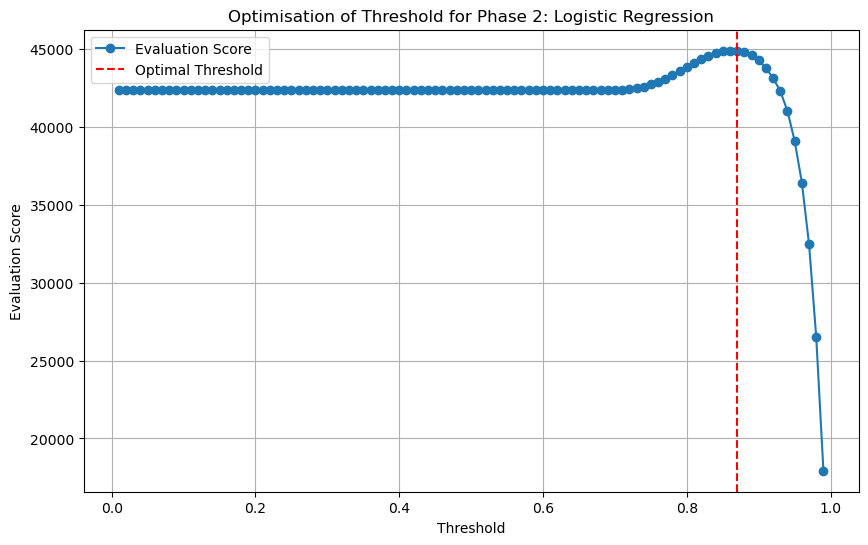

In [3]:
# Train Logistic Regression Model
phase_2_logistic = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
)
phase_2_logistic.fit(x_train, y_train)

# Predict on validation set
phase_2_logistic_pred_df = shrunk_val_item_df.copy()
phase_2_logistic_pred_df['item_prob'] = phase_2_logistic.predict_proba(x_val)[:, 1]

# Optimise threshold and evaluate
phase_2_best_logistic_threshold = optimise_threshold(
    'Phase 2: Logistic Regression',
    phase_2_logistic_pred_df,
    shrunk_val_item_df,
    True,
    True
)

In [4]:
# Print weights of the logistic regression model
print("Phase 2: Logistic Regression Weights")
for feature, weight in zip(item_features, phase_2_logistic.coef_[0]):
    print(f"{feature}: {weight:.4f}")

Phase 2: Logistic Regression Weights
item_clicks_z: 0.6352
item_time_z: 0.1406
day_of_week: -0.0252
hour_sin: 0.0946
hour_cos: -0.1065
item_propensity: 27.0556
item_categories_z: -0.0071


An interesting observation during Jaccard score optimisation is the presence of a sharp “jump” in score at a specific threshold, followed by a rapid decline. This suggests that the model tends to be overconfident, assigning high probabilities to many items, which can initially help recall but eventually harm precision. The threshold at which the Jaccard score peaks likely represents the model’s **optimal trade-off** point where it captures the most true positives without being penalised by an excess of false positives. Since the Jaccard component of the challenge metric only diminishes with false predictions (rather than becoming negative), this peak reflects the best achievable score, where the model effectively balances precision and recall within the positive contribution zone.

We note that the logistic regression model performs generally well on the item prediction task, with a precision of 0.56 at a threshold of 0.87.

### 2.2 Gradient Boosting

We train a gradient boosting model to predict whether an item will be purchased in a session. We then optimise the threshold for the model to maximise the evaluation measure. As with the previous phase, we use a standard set of hyperparameters for the model and leave hyperparameter tuning for future work.

--- Model: Phase 2: Gradient Boosting ---
Optimal Threshold: 0.90
Evaluation Score: 46448.7453
ROC AUC: 0.8051
Precision: 0.6004
Recall: 0.9090


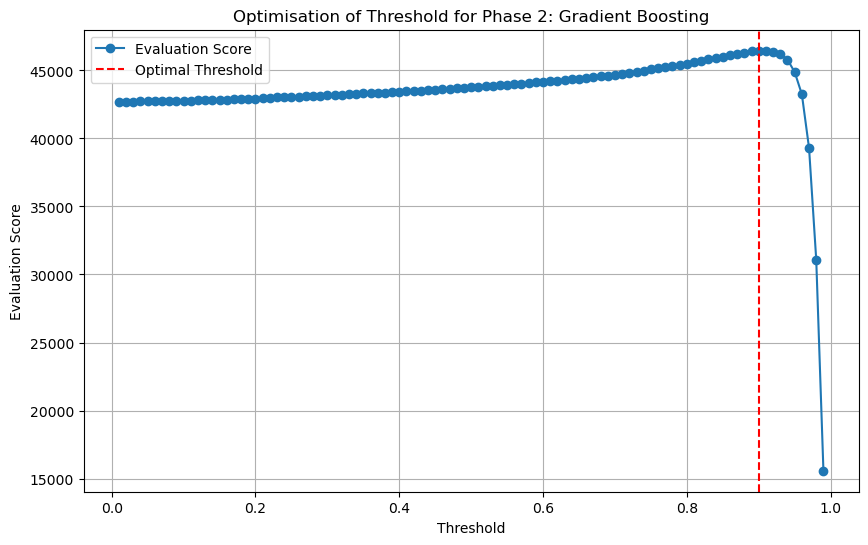

In [5]:
# Train Gradient Boosting Model
phase_2_gbm = LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_estimators=1000,
    verbose=-1,
)
phase_2_gbm.fit(x_train, y_train)

# Predict on validation set
phase_2_gbm_pred_df = shrunk_val_item_df.copy()
phase_2_gbm_pred_df['item_prob'] = phase_2_gbm.predict_proba(x_val)[:, 1] # type: ignore

# Optimise threshold and evaluate
phase_2_best_gbm_threshold = optimise_threshold(
    'Phase 2: Gradient Boosting',
    phase_2_gbm_pred_df,
    shrunk_val_item_df,
    True,
    True
)

As with the logistic regression model, the gradient boosting model performs well on the item prediction task, with a precision of 0.6 at a threshold of 0.9. As previously observed with the logistic regression model, the gradient boosting model also exhibits an increase in Jaccard score as the threshold is increased, followed by a rapid decline. This suggests that the model is also overconfident in its predictions, and thus the optimal threshold is likely to be the point at which the Jaccard score peaks.

### 2.3 Feedforward Neural Network

We then train a feedforward neural network to predict whether an item will be purchased in a session. Similar to the previous phase, we use a standard set of hyperparameters for the model and leave hyperparameter tuning for future work.

Starting training...
Hidden layer size: 8
Batch size: 2048
Number of epochs: 50

Epoch [10/50], Loss: 0.1611
Epoch [20/50], Loss: 0.1599
Epoch [30/50], Loss: 0.1597
Epoch [40/50], Loss: 0.1596
Epoch [50/50], Loss: 0.1595
Model saved to ./models/phase_2_fnn_model.pth
--- Model: Phase 2: Feedforward Neural Network ---
Optimal Threshold: 0.88
Evaluation Score: 46336.5967
ROC AUC: 0.7856
Precision: 0.5908
Recall: 0.9057


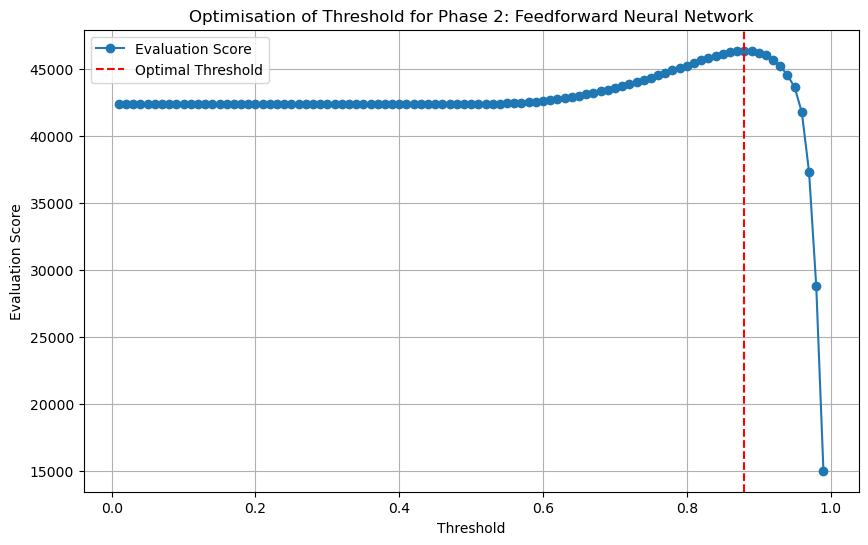

In [6]:
# Train Feedforward Neural Network Model
fnn_model = FNNModel(
    input_size=len(item_features),
    hidden_size=8,
    batch_size=2048,
)
fnn_model.train_model(
    x_train,
    y_train,
    num_epochs=50,
)

# Save model
fnn_model.save_model(FNN_MODEL_PHASE_2)

# Predict on validation set
phase_2_fnn_pred_df = shrunk_val_item_df.copy()
phase_2_fnn_pred_df['item_prob'] = fnn_model.predict_prob(x_val)

# Optimise threshold and evaluate
phase_2_best_fnn_threshold = optimise_threshold(
    'Phase 2: Feedforward Neural Network',
    phase_2_fnn_pred_df,
    shrunk_val_item_df,
    True,
    True
)

We observe that the FNN model has similar performance to the Gradient Boosting model, with a precision of 0.59 at a threshold of 0.88. The Jaccard score also exhibits a similar pattern to the previous models. These results suggest that the FNN model is able to capture the signal in the data, and it is likely that proper tuning of the hyperparameters would result in a model that performs better than the Gradient Boosting model.

In [7]:
# Free up memory
del x_train, y_train, x_val, y_val
del train_item_df, val_item_df, shrunk_train_item_df, shrunk_val_item_df

## 3. Model Selection

Given the performance of the models on the validation set, we note that Gradient Boosting is the most suitable model for the session purchase classification task, as it is able to capture more of the signal in the data than the logistic regression model and the feedforward neural network model and deliver a net positive score from the validation data. However, the recall of the model is still considerably low, and thus it should be considered that the model is not able to reliably predict whether a session will result in a purchase.

For the item purchase classification task, we note that both the Gradient Boosting and FNN models perform well, with a precision of 0.6 and 0.59 respectively at their optimal thresholds. However, the Gradient Boosting model has a slightly higher precision and is thus selected as the final model for the item purchase classification task. The FNN model is also a strong contender, and it is likely that with proper hyperparameter tuning, it could outperform the Gradient Boosting model.

Therefore we shall proceed to train the following models on the item purchase classification task:

- Session Classification: **Gradient Boosting**
- Item Classification: **Gradient Boosting**

## 4. Training and Evaluation

We then proceed to train the selected models on the full training set (training and validation sets) and evaluate the models on the test set. We use the evaluation score to evaluate the performance of the models on the test set. Note we continue to use the upsampled training set to ensure that the models are able to learn the signal in the data effectively.

### 4.1 Session Classification Model

In [2]:
# Load session training data and
# extract features and labels
train_val_session_df = pd.read_csv(TRAIN_VAL_SESSION)
test_session_df = pd.read_csv(TEST_SESSION)

# Upsample training data to balance things out
majority_class = train_val_session_df[train_val_session_df['session_purchase'] == 0]
minority_class = train_val_session_df[train_val_session_df['session_purchase'] == 1]

minority_upsampled = resample(
    minority_class,
    replace=True,  # sample with replacement
    n_samples=len(majority_class),  # to match majority class
    random_state=RANDOM_STATE  # reproducible results
)

train_val_session_df: pd.DataFrame = pd.concat([majority_class, minority_upsampled]) # type: ignore
train_val_session_df = train_val_session_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Shrink dataframes for score calculation
shrunk_train_val_session_df = train_val_session_df.copy().drop(session_features_shrink, axis=1)
shrunk_test_session_df = test_session_df.copy().drop(session_features_shrink, axis=1)

x_train_session = train_val_session_df[session_features].to_numpy()
y_train_session = train_val_session_df['session_purchase'].to_numpy()
x_test_session = test_session_df[session_features].to_numpy()
y_test_session = test_session_df['session_purchase'].to_numpy()

# Phase 1: Train Gradient Boosting Model
phase_1_gbm = LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_estimators=1000,
    verbose=-1,
)
phase_1_gbm.fit(x_train_session, y_train_session)

# Optimal threshold for Phase 1
phase_1_threshold = 0.95

### 4.2 Item Classification Model

In [5]:
# Load item training data and
# extract features and labels
train_val_item_df = pd.read_csv(TRAIN_VAL_ITEM)
test_item_df = pd.read_csv(TEST_ITEM)

# Filter for sessions that resulted in a purchase
train_val_item_df = train_val_item_df[train_val_item_df['session_purchase'] == 1]
test_item_df = test_item_df[test_item_df['session_purchase'] == 1]

# Upsample training data to balance things out
majority_class = train_val_item_df[train_val_item_df['item_purchase'] == 0]
minority_class = train_val_item_df[train_val_item_df['item_purchase'] == 1]

minority_upsampled = resample(
    minority_class,
    replace=True,  # sample with replacement
    n_samples=len(majority_class),  # to match majority class
    random_state=RANDOM_STATE  # reproducible results
)

train_val_item_df: pd.DataFrame = pd.concat([majority_class, minority_upsampled]) # type: ignore
train_val_item_df = train_val_item_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Shrink dataframes for score calculation
shrunk_train_val_item_df = train_val_item_df.copy().drop(item_features_shrink, axis=1)
shrunk_test_item_df = test_item_df.copy().drop(item_features_shrink, axis=1)

x_train_item = train_val_item_df[item_features].to_numpy()
y_train_item = train_val_item_df['item_purchase'].to_numpy()
x_test_item = test_item_df[item_features].to_numpy()
y_test_item = test_item_df['item_purchase'].to_numpy()

# Phase 2: Train Gradient Boosting Model
phase_2_gbm = LGBMClassifier(
    objective='binary',
    random_state=RANDOM_STATE,
    n_estimators=1000,
    verbose=-1,
)
phase_2_gbm.fit(x_train_item, y_train_item)

# Optimal threshold for Phase 2
phase_2_threshold = 0.9

### 4.4 Evaluation

Here we perform our final inference on the test set, and evaluate the performance of the developed prediction algorithm.

In [6]:
# --- Phase 1: Predict Sessions ---

phase_1_gbm_pred_df = shrunk_test_session_df.copy()
phase_1_gbm_pred_df['session_prob'] = phase_1_gbm.predict_proba(x_test_session)[:, 1] # type: ignore

# Evaluate Phase 1
evaluate_stage(
    'Gradient Boosting',
    phase_1_gbm_pred_df,
    shrunk_test_session_df,
    1,
    phase_1_threshold,
)

# Filter item data for predicted sessions from Phase 1
predicted_sessions_df = phase_1_gbm_pred_df[phase_1_gbm_pred_df['session_prob'] >= phase_1_threshold]
predicted_sessions = set(predicted_sessions_df['session_id'].unique())

filtered_test_item_df = test_item_df[test_item_df['session_id'].isin(predicted_sessions)]

# --- Phase 2: Predict Items ---

phase_2_gbm_pred_df = shrunk_test_item_df.copy()
phase_2_gbm_pred_df['item_prob'] = phase_2_gbm.predict_proba(x_test_item)[:, 1] # type: ignore

# Evaluate Phase 2
evaluate_stage(
    'Gradient Boosting',
    phase_2_gbm_pred_df,
    shrunk_test_item_df,
    2,
    phase_2_threshold,
)

predicted_items_df = phase_2_gbm_pred_df[phase_2_gbm_pred_df['item_prob'] >= phase_2_threshold].copy()

# Save predictions
predicted_sessions_df.to_csv(RESULT_SESSIONS, index=False)
predicted_items_df.to_csv(RESULT_ITEMS, index=False)

# Evaluate overall model performance
evaluate_model(
    predicted_items_df,
    shrunk_test_item_df,
)

--- Phase 1: Gradient Boosting ---
Evaluation Score: 20.3226
Max Possible Score: 9352.1972
Percentage of Max Score: 0.22%
ROC AUC: 0.8174
Precision: 0.5631
Recall: 0.0097
--- Phase 2: Gradient Boosting ---
Evaluation Score: 11989.2244
Max Possible Score: 169809.0000
Percentage of Max Score: 7.06%
ROC AUC: 0.8070
Precision: 0.9148
Recall: 0.0499
--- Overall Statistics ---
Evaluation Score: 29516.2244
Max Possible Score: 275633.7059
Percentage of Max Score: 10.71%


## 5. Conclusion

Evaluating the performance of the final prediction algorithm on the test set, we note that the model obtains a positive score of 29516, which is about 10% of the maximum possible score. Despite the model being able to capture some of the signal in the data, it is clear that there is still a considerable amount of room for improvement. The model is not able to reliably predict whether a session will result in a purchase, and thus it is likely that further feature engineering and model development is required to improve the performance of the model.

The results of the model are saved in the `results/` folder in csv format, with the predictions for sessions and items in separate files.